#**1. Importing the Dependencies**

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder  #encode categorical features
from imblearn.over_sampling import SMOTE  # for uniformly distributed target classes
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBRFClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import pickle  #to save files that can be used later


task: try create an ensemble of these 3 models

#**2. Data Loading and Understanding**

In [ ]:
#load the csv data to a pandas dataframe
df = pd.read_csv("/content/drive/MyDrive/Customer Churn/WA_Fn-UseC_-Telco-Customer-Churn.csv")
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [ ]:
df.shape # to determine number of rows and columns

(7043, 21)

In [ ]:
pd.set_option("display.max_columns",None)  # for fixing something related to truncated .. dk search

In [ ]:
df.info()  #gives data type as well
df.isnull().sum() #similar as above

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


,0
customerID,0
gender,0
SeniorCitizen,0
Partner,0
Dependents,0
tenure,0
PhoneService,0
MultipleLines,0
InternetService,0
OnlineSecurity,0


need to convert total charges to float from currently object

In [ ]:
#dropping customer id column, as not needed for modeling
df=df.drop(columns=["customerID"])
df.head(2)

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No


In [ ]:
# printing unique values in all the columns, to ensure/check which ones are numerical and which are categorical
numerical_features=["tenure", "MonthlyCharges", "TotalCharges"]
for col in df.columns:
  if col not in numerical_features:
    print(col, df[col].unique())
    print("-"*50)

gender ['Female' 'Male']
--------------------------------------------------
SeniorCitizen [0 1]
--------------------------------------------------
Partner ['Yes' 'No']
--------------------------------------------------
Dependents ['No' 'Yes']
--------------------------------------------------
PhoneService ['No' 'Yes']
--------------------------------------------------
MultipleLines ['No phone service' 'No' 'Yes']
--------------------------------------------------
InternetService ['DSL' 'Fiber optic' 'No']
--------------------------------------------------
OnlineSecurity ['No' 'Yes' 'No internet service']
--------------------------------------------------
OnlineBackup ['Yes' 'No' 'No internet service']
--------------------------------------------------
DeviceProtection ['No' 'Yes' 'No internet service']
--------------------------------------------------
TechSupport ['No' 'Yes' 'No internet service']
--------------------------------------------------
StreamingTV ['No' 'Yes' 'No internet 

In [ ]:
#df["TotalCharges"] = df["TotalCharges"].astype(float)  #" " is used for missing values

In [ ]:
df[df["TotalCharges"]==" "] #prints rows with empty total charges column

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
488,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,No,Yes,Yes,Yes,No,Two year,Yes,Bank transfer (automatic),52.55,,No
753,Male,0,No,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.25,,No
936,Female,0,Yes,Yes,0,Yes,No,DSL,Yes,Yes,Yes,No,Yes,Yes,Two year,No,Mailed check,80.85,,No
1082,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.75,,No
1340,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,Yes,Yes,Yes,Yes,No,Two year,No,Credit card (automatic),56.05,,No
3331,Male,0,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,19.85,,No
3826,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.35,,No
4380,Female,0,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.00,,No
5218,Male,0,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,Yes,Mailed check,19.70,,No
6670,Female,0,Yes,Yes,0,Yes,Yes,DSL,No,Yes,Yes,Yes,Yes,No,Two year,No,Mailed check,73.35,,No


In [ ]:
len(df[df["TotalCharges"]==" "])

11

In [ ]:
#replace empty total charges by
df["TotalCharges"]= df["TotalCharges"].replace(" ","0.0")

In [ ]:
df["TotalCharges"] = df["TotalCharges"].astype(float)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            7043 non-null   object 
 1   SeniorCitizen     7043 non-null   int64  
 2   Partner           7043 non-null   object 
 3   Dependents        7043 non-null   object 
 4   tenure            7043 non-null   int64  
 5   PhoneService      7043 non-null   object 
 6   MultipleLines     7043 non-null   object 
 7   InternetService   7043 non-null   object 
 8   OnlineSecurity    7043 non-null   object 
 9   OnlineBackup      7043 non-null   object 
 10  DeviceProtection  7043 non-null   object 
 11  TechSupport       7043 non-null   object 
 12  StreamingTV       7043 non-null   object 
 13  StreamingMovies   7043 non-null   object 
 14  Contract          7043 non-null   object 
 15  PaperlessBilling  7043 non-null   object 
 16  PaymentMethod     7043 non-null   object 


In [ ]:
# checking the class distribution of target column
print(df["Churn"].value_counts())

Churn
No     5174
Yes    1869
Name: count, dtype: int64


we need to balance this dataset, we need to perform downsampling or upsampling- decrese majority class or decrease minority class

**Insights:**
1. removed customerID as not required for modelling.
2. No missing values in the dataset
3. Missing values  in TotalCharges column were replaced with 0.0
4. Class imbalance identified in the target

#3.EDA

In [ ]:
df.shape

(7043, 20)

In [ ]:
df.columns

Index(['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure',
       'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity',
       'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV',
       'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod',
       'MonthlyCharges', 'TotalCharges', 'Churn'],
      dtype='object')

In [ ]:
df.head(2)

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No


In [ ]:
df.describe()  #works only on encoded/numerical features only

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges
count,7043.000000,7043.000000,7043.000000,7043.000000
mean,0.162147,32.371149,64.761692,2279.734304
std,0.368612,24.559481,30.090047,2266.794470
min,0.000000,0.000000,18.250000,0.000000
25%,0.000000,9.000000,35.500000,398.550000
50%,0.000000,29.000000,70.350000,1394.550000
75%,0.000000,55.000000,89.850000,3786.600000
max,1.000000,72.000000,118.750000,8684.800000


##Numerical feature analysis

Understand the distribution of the numerical features

In [ ]:
def plot_histogram(df, column_name):
  plt.figure(figsize=(5,3))
  sns.histplot(df[column_name], kde=True)
  plt.title(f"Distribution of {column_name}")

  #calc mean and median
  col_mean=df[column_name].mean()
  col_median=df[column_name].median()

  #add lines for mean and median on the graph
  plt.axvline(col_mean, color="red", linestyle="--", label="mean")
  plt.axvline(col_median, color="green", linestyle="-", label="median")
  plt.legend() #label is shown here

  plt.show()

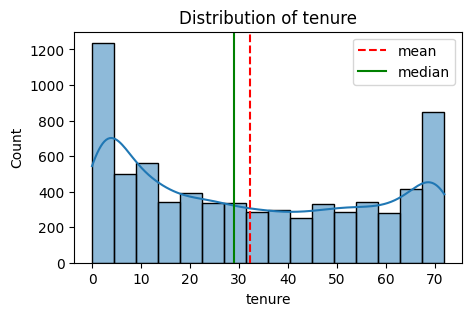

In [ ]:
plot_histogram(df, "tenure")

not a normal distribution

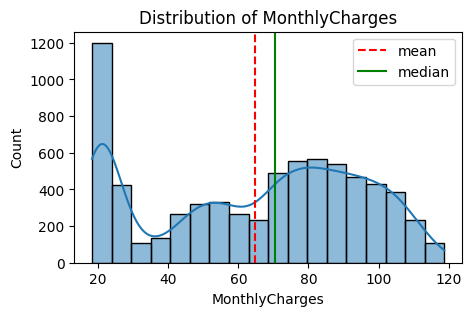

In [ ]:
plot_histogram(df, "MonthlyCharges")

not a normal distribution

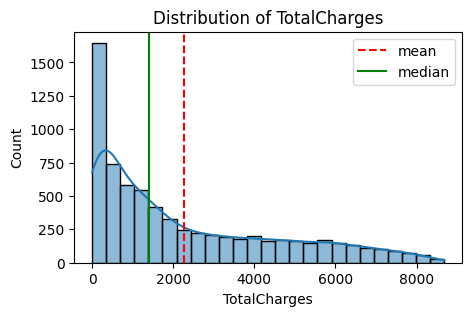

In [ ]:
plot_histogram(df, "TotalCharges")

not a normal distribution
skewed distribution- looks right

we perform feature scaling (standard scaler mean=0 sd=1), to get normal distribution (as some models expect bell shaped)

some models are not sensitive to data being normal distribution

*Boxplot function*

In [ ]:
def plot_boxplot(df, column_name):
  plt.figure(figsize=(5,3))
  sns.boxplot(y=df[column_name])
  plt.title(f"Distribution of {column_name}")

  plt.ylabel(column_name)
  plt.show

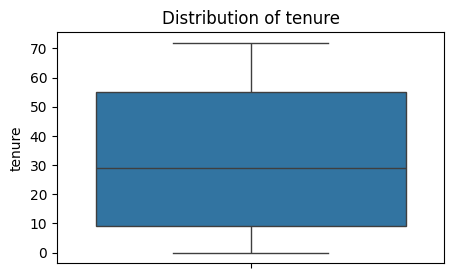

In [ ]:
plot_boxplot(df, "tenure")

no outliers (dots/arrows below or above the bordered line)

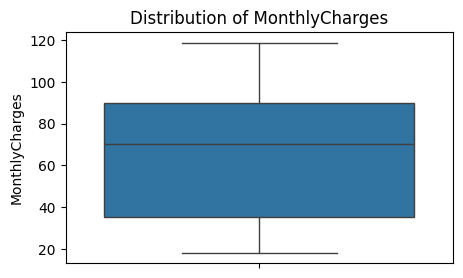

In [ ]:
plot_boxplot(df, "MonthlyCharges")

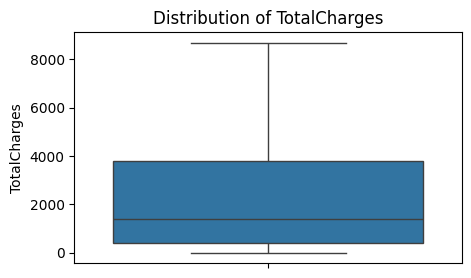

In [ ]:
plot_boxplot(df, "TotalCharges")

*Correlation HeatMap of numerical features*

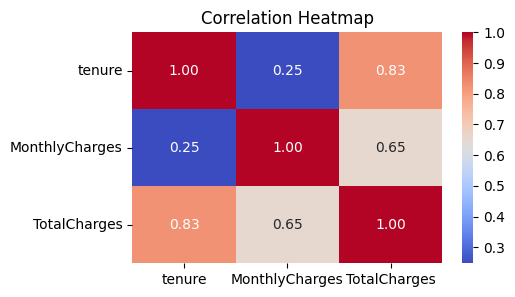

In [ ]:
#correlation atrix -heatmap
plt.figure(figsize=(5,3))
sns.heatmap(df[["tenure", "MonthlyCharges", "TotalCharges"]].corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()

when there are two columns that are highly correlated , we **usually** drop one of the columns and work with the other alone.

we can also do an iterative process, use both in the 1st iteration, and in the 2nd iteration we can drop and see if the performance improves

##Categorical Features - Analysis

In [ ]:
df.columns

Index(['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure',
       'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity',
       'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV',
       'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod',
       'MonthlyCharges', 'TotalCharges', 'Churn'],
      dtype='object')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            7043 non-null   object 
 1   SeniorCitizen     7043 non-null   int64  
 2   Partner           7043 non-null   object 
 3   Dependents        7043 non-null   object 
 4   tenure            7043 non-null   int64  
 5   PhoneService      7043 non-null   object 
 6   MultipleLines     7043 non-null   object 
 7   InternetService   7043 non-null   object 
 8   OnlineSecurity    7043 non-null   object 
 9   OnlineBackup      7043 non-null   object 
 10  DeviceProtection  7043 non-null   object 
 11  TechSupport       7043 non-null   object 
 12  StreamingTV       7043 non-null   object 
 13  StreamingMovies   7043 non-null   object 
 14  Contract          7043 non-null   object 
 15  PaperlessBilling  7043 non-null   object 
 16  PaymentMethod     7043 non-null   object 


*Count Plot for categorical columns*

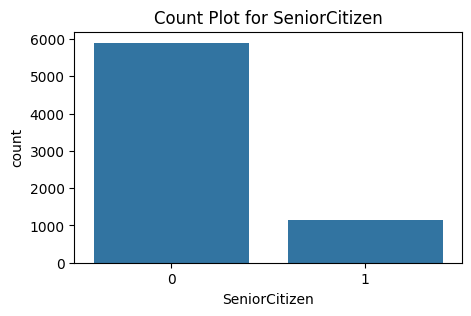

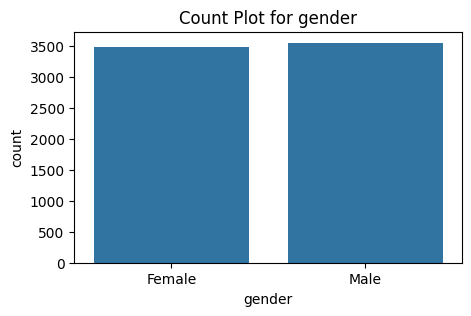

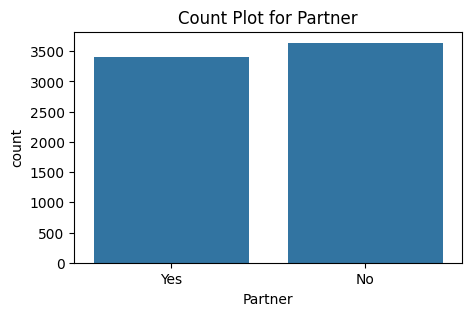

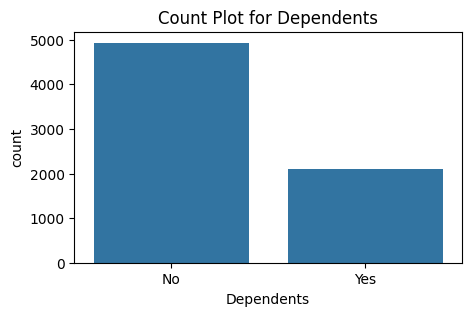

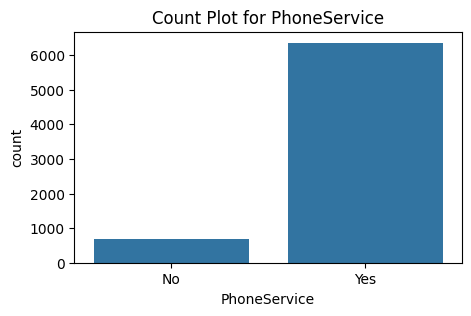

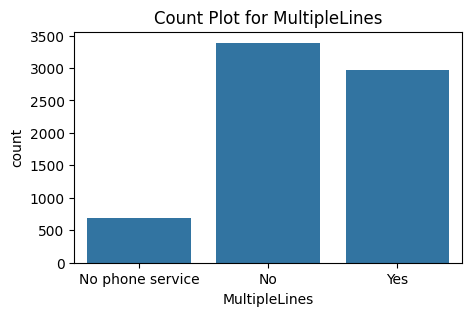

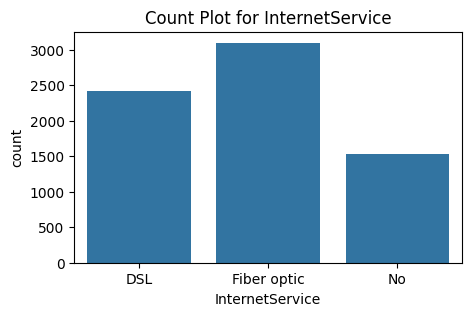

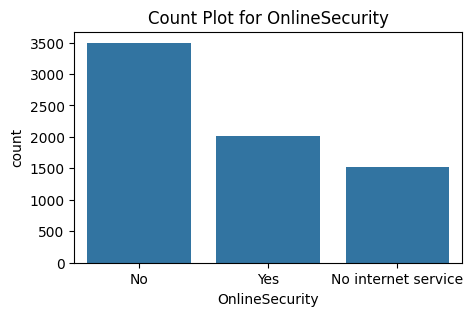

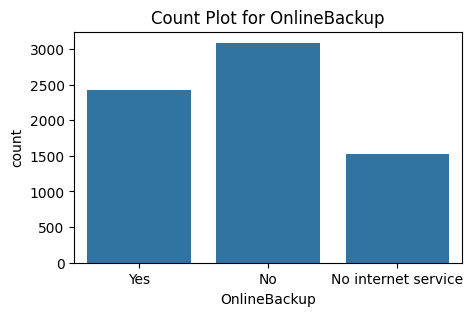

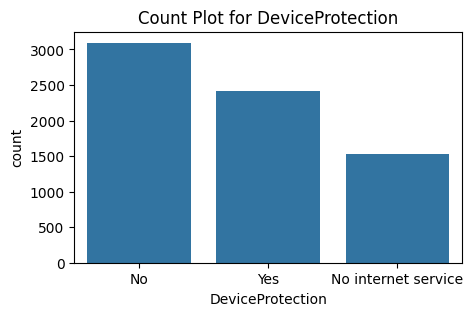

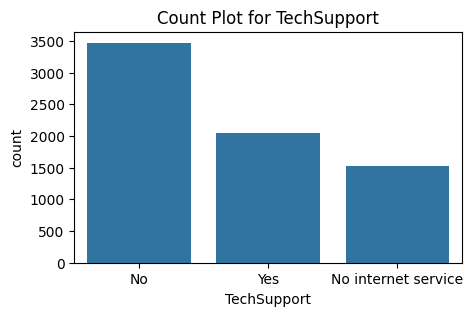

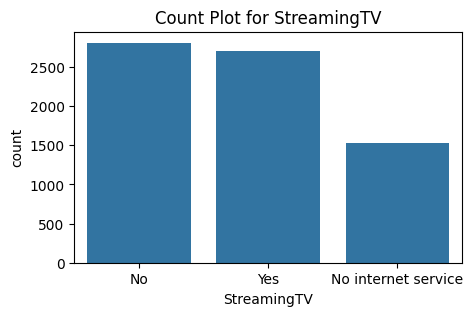

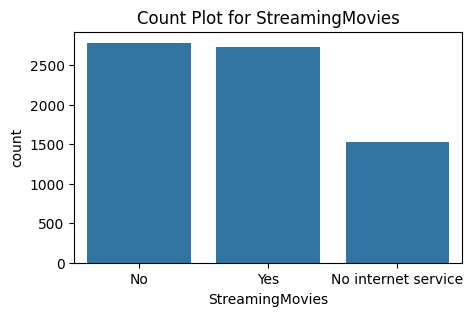

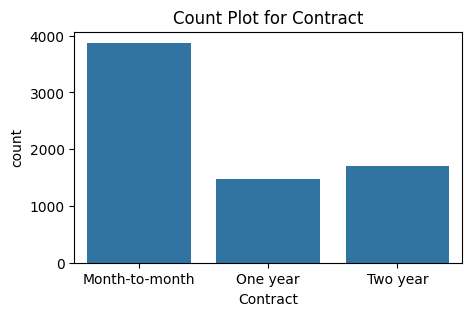

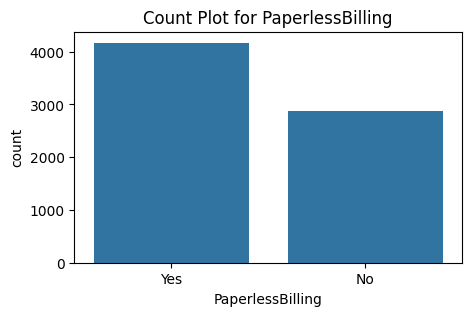

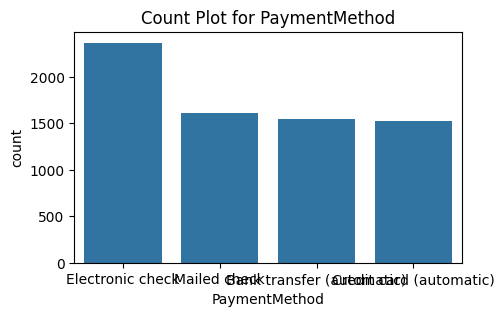

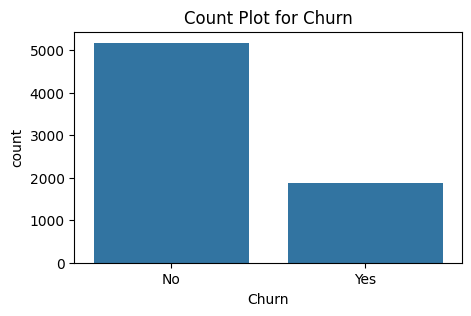

In [ ]:
object_cols=df.select_dtypes(include='object').columns.to_list()
object_cols=["SeniorCitizen"]+object_cols

for col in object_cols:
  plt.figure(figsize=(5,3))
  sns.countplot(x=df[col])
  plt.title(f"Count Plot for {col}")
  plt.show()
#object_cols

imbalance in features is not critical for many models

BUT imbalance in target is always an ISSUE

#4. Data Preprocessing

In [ ]:
df.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


Label Encoding of Target Column

In [ ]:
df["Churn"] = df["Churn"].replace({"Yes" : 1, "No" : 0})

/tmp/ipython-input-119-519925226.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df["Churn"] = df["Churn"].replace({"Yes" : 1, "No" : 0})


In [ ]:
df.head(3)

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,0
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,0
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,1


Label Encoding of other categorical features

In [ ]:
#columns with object type
object_cols=df.select_dtypes(include='object').columns.to_list()

In [ ]:
print(object_cols)

['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod']


In [ ]:
# initialize a dictionary to save the encoders
encoders = {}

# apply label encoding and store the encoders
for column in object_cols:
  label_encoder = LabelEncoder()
  df[column] = label_encoder.fit_transform(df[column])
  encoders[column] = label_encoder


# save the encoders to a pickle file
with open("encoders.pkl", "wb") as f:
  pickle.dump(encoders, f)


In [ ]:
encoders

{'gender': LabelEncoder(),
 'Partner': LabelEncoder(),
 'Dependents': LabelEncoder(),
 'PhoneService': LabelEncoder(),
 'MultipleLines': LabelEncoder(),
 'InternetService': LabelEncoder(),
 'OnlineSecurity': LabelEncoder(),
 'OnlineBackup': LabelEncoder(),
 'DeviceProtection': LabelEncoder(),
 'TechSupport': LabelEncoder(),
 'StreamingTV': LabelEncoder(),
 'StreamingMovies': LabelEncoder(),
 'Contract': LabelEncoder(),
 'PaperlessBilling': LabelEncoder(),
 'PaymentMethod': LabelEncoder()}

In [ ]:
df.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,0,0,1,0,1,0,1,0,0,2,0,0,0,0,0,1,2,29.85,29.85,0
1,1,0,0,0,34,1,0,0,2,0,2,0,0,0,1,0,3,56.95,1889.50,0
2,1,0,0,0,2,1,0,0,2,2,0,0,0,0,0,1,3,53.85,108.15,1
3,1,0,0,0,45,0,1,0,2,0,2,2,0,0,1,0,0,42.30,1840.75,0
4,0,0,0,0,2,1,0,1,0,0,0,0,0,0,0,1,2,70.70,151.65,1


we can also try one hot encoding,
label encoding is sufficient for XGBoost

**Training and Testing Data Split**

In [ ]:
#split out features and target

In [ ]:
X= df.drop(columns=["Churn"])
y=df["Churn"]

One should definitely apply Standard Scaling for models like logical Regression, Vector for the columns tenure, monthly charges, total charges, to get normal distribution

In [ ]:
X.head(2)

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,0,0,1,0,1,0,1,0,0,2,0,0,0,0,0,1,2,29.85,29.85
1,1,0,0,0,34,1,0,0,2,0,2,0,0,0,1,0,3,56.95,1889.50


In [ ]:
X_train, X_test, y_train, y_test= train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
print(y_train.shape)

(5634,)


In [ ]:
print(y_train.value_counts())

Churn
0    4138
1    1496
Name: count, dtype: int64


we need to handle this imbalance

We apply SMOTE
Synthetic Minority Oversampling Technique

In [ ]:
smote = SMOTE(random_state=42)

In [ ]:
X_train_smote, y_train_smote= smote.fit_resample(X_train, y_train)

In [ ]:
print(y_train_smote.shape)

(8276,)


In [ ]:
print(y_train_smote.value_counts())

Churn
0    4138
1    4138
Name: count, dtype: int64


#5. Model Training

task: to try training with hyper parameter training

Currently, training with default hyperparameters

In [ ]:
#dictionary of models
models = {
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42),
    "XGBoost": XGBRFClassifier(random_state=42)
}

In [ ]:
#dictionary to store the cross validation results
cv_scores = {}

#perform 5-fold cross validation for each model
for model_name, model in models.items():
  print(f"Training {model_name} with default parameters")
  scores= cross_val_score(model, X_train_smote, y_train_smote, cv=5, scoring="accuracy")
  cv_scores[model_name] = scores
  print(f"{model_name} cross-validation accuracy: {np.mean(scores): .2f}")
  print("-"*50)


Training Decision Tree with default parameters
Decision Tree cross-validation accuracy:  0.78
--------------------------------------------------
Training Random Forest with default parameters
Random Forest cross-validation accuracy:  0.84
--------------------------------------------------
Training XGBoost with default parameters
XGBoost cross-validation accuracy:  0.81
--------------------------------------------------


In [ ]:
cv_scores

{'Decision Tree': array([0.68297101, 0.71299094, 0.82175227, 0.83564955, 0.83564955]),
 'Random Forest': array([0.72524155, 0.77824773, 0.90513595, 0.89425982, 0.90090634]),
 'XGBoost': array([0.71799517, 0.77220544, 0.85498489, 0.83987915, 0.85135952])}

task : stratified k-fold?

Random Forest to be trained further

In [ ]:
rfc = RandomForestClassifier(random_state=42)
rfc.fit(X_train_smote, y_train_smote)

RandomForestClassifier(random_state=42)

In [ ]:
print(y_test.value_counts())

Churn
0    1036
1     373
Name: count, dtype: int64


#6.Model Evaluation

In [ ]:
#evaluate on test data
y_test_predict = rfc.predict(X_test)

print("Accuracy Score:\n", accuracy_score(y_test, y_test_predict))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_test_predict))
print("Classification Report:\n", classification_report(y_test, y_test_predict))

Accuracy Score:
 0.7785663591199432
Confusion Matrix:
 [[878 158]
 [154 219]]
Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.85      0.85      1036
           1       0.58      0.59      0.58       373

    accuracy                           0.78      1409
   macro avg       0.72      0.72      0.72      1409
weighted avg       0.78      0.78      0.78      1409



accuracy is not so realiable due to test_data imbalance

In [ ]:
X.columns.tolist()

['gender',
 'SeniorCitizen',
 'Partner',
 'Dependents',
 'tenure',
 'PhoneService',
 'MultipleLines',
 'InternetService',
 'OnlineSecurity',
 'OnlineBackup',
 'DeviceProtection',
 'TechSupport',
 'StreamingTV',
 'StreamingMovies',
 'Contract',
 'PaperlessBilling',
 'PaymentMethod',
 'MonthlyCharges',
 'TotalCharges']

In [ ]:
# save the trained model as a pickle file
model_data = {"model":rfc, "features_names": X.columns.tolist()}
with open("customer_churn_model.pkl", "wb") as f:
  pickle.dump(model_data,f)

#7. Load the saved model and build a predictive System

In [ ]:
#loading the model and the encoders

with open("customer_churn_model.pkl", "rb") as f:
  model_data = pickle.load(f)

loaded_model= model_data["model"]
feature_names = model_data["features_names"]

In [ ]:
print(loaded_model)

RandomForestClassifier(random_state=42)


In [ ]:
data_dict = {'gender': 'Female', 'SeniorCitizen': 0, 'Partner': 'Yes', 'Dependents': 'No', 'tenure': 1, 'PhoneService': 'No', 'MultipleLines': 'No phone service', 'InternetService': 'DSL', 'OnlineSecurity': 'No', 'OnlineBackup': 'Yes', 'DeviceProtection': 'No', 'TechSupport': 'No', 'StreamingTV': 'No', 'StreamingMovies': 'No', 'Contract': 'Month-to-month', 'PaperlessBilling': 'Yes', 'PaymentMethod': 'Electronic check', 'MonthlyCharges': 29.85, 'TotalCharges': 29.85}
print(data_dict)

{'gender': 'Female', 'SeniorCitizen': 0, 'Partner': 'Yes', 'Dependents': 'No', 'tenure': 1, 'PhoneService': 'No', 'MultipleLines': 'No phone service', 'InternetService': 'DSL', 'OnlineSecurity': 'No', 'OnlineBackup': 'Yes', 'DeviceProtection': 'No', 'TechSupport': 'No', 'StreamingTV': 'No', 'StreamingMovies': 'No', 'Contract': 'Month-to-month', 'PaperlessBilling': 'Yes', 'PaymentMethod': 'Electronic check', 'MonthlyCharges': 29.85, 'TotalCharges': 29.85}


In [ ]:
input_data = {
    'gender': 'Female',
    'SeniorCitizen': 0,
    'Partner': 'Yes',
    'Dependents': 'No',
    'tenure': 1,
    'PhoneService': 'No',
    'MultipleLines': 'No phone service',
    'InternetService': 'DSL',
    'OnlineSecurity': 'No',
    'OnlineBackup': 'Yes',
    'DeviceProtection': 'No',
    'TechSupport': 'No',
    'StreamingTV': 'No',
    'StreamingMovies': 'No',
    'Contract': 'Month-to-month',
    'PaperlessBilling': 'Yes',
    'PaymentMethod': 'Electronic check',
    'MonthlyCharges': 29.85,
    'TotalCharges': 29.85
}


input_data_df = pd.DataFrame([input_data])

with open("encoders.pkl", "rb") as f:
  encoders = pickle.load(f)


# encode categorical featires using teh saved encoders
for column, encoder in encoders.items():
  input_data_df[column] = encoder.transform(input_data_df[column])

# make a prediction
prediction = loaded_model.predict(input_data_df)
pred_prob = loaded_model.predict_proba(input_data_df)

print(prediction)

# results
print(f"Prediction: {'Churn' if prediction[0] == 1 else 'No Churn'}")
print(f"Prediciton Probability: {pred_prob}")

[0]
Prediction: No Churn
Prediciton Probability: [[0.78 0.22]]


In [ ]:
input_data_df

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,0,0,1,0,1,0,1,0,0,2,0,0,0,0,0,1,2,29.85,29.85
